In [2]:
import numpy as np, matplotlib.pyplot as plt, glob, os, pandas as pd, copy, \
    skimage.segmentation as segm, networkx as nx, simplification.cutil as simpl, \
    scipy.ndimage as ndimage, matplotlib.colors as mplcol, matplotlib.cm as cm, json
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm_notebook as tqdm
import shapely.ops, shapely.geometry as geom
from skimage.measure import label

### Specify data files to display

In [23]:
fnameP = 'rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.clusters.npy'

In [24]:
fnames = [x for x in glob.glob('\\\\?\\Z:\\behavior\\*\\wavelet\\{}'.format(fnameP)) if 'RIG' not in x]
len(fnames)

21

In [37]:
arrClusters = [np.load(fn)[:,0] for fn in fnames]

In [25]:
def toNumber(x):
    try:
        return int(x)
    except:
        return -1
    
def loadLabels(fnameLabels):
    txtClusterLabels = ''
    with open(fnameLabels, 'r') as f:
        txtClusterLabels = f.read()
    clusterLabels = {}
    curLabel = ''
    for line in txtClusterLabels.split('\n'):
        if ':' in line:
            curLabel = line[:line.find(':')]
        elif len(line.strip()) > 0:
            clusterLabels[curLabel] = [toNumber(x) for x in line.split(',') if toNumber(x) >= 0]
    return clusterLabels

In [26]:
fnameClusterLabelsP = '\\\\?\\Y:\\wavelet\\clips\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd\\cluster_names.txt'

clusterLabels = loadLabels(fnameClusterLabelsP)
clusterLabelsUnique = list(clusterLabels.keys())
clusterLabelsUnique = [x for x in clusterLabelsUnique if x not in ['noisy',]]

In [34]:
fnamesTracking = [glob.glob(os.path.abspath(os.path.join(os.path.dirname(fn), '../croprot/*_dlc_abs_filt_interp_mvmt_noborder.npy')))[0] for fn in fnames]

In [36]:
arrTracking = [np.load(fn) for fn in fnamesTracking]

In [38]:
arrTracking[0].shape, arrClusters[0].shape

((509493, 26, 3), (509493,))

In [55]:
dist13 = np.linalg.norm(arrTracking[0][:,13,0:2] - arrTracking[0][:,1,0:2], axis=1)

In [63]:
clusterID = clusterLabels['extrude'][8]

In [ ]:
data = []
for fnameIdx in tqdm(range(len(fnames)), leave=False):
    for cltype in tqdm(['extrude', 'extrude-slow'], leave=False):
        for clusterID in clusterLabels[cltype]:
            try:
                dist13 = np.linalg.norm(arrTracking[fnameIdx][:,13,0:2] - arrTracking[fnameIdx][:,1,0:2], axis=1)
                dist13 = dist13 - pd.DataFrame(dist13).rolling(window=50).mean().fillna(method='bfill').fillna(method='ffill').values[:,0]
                ts = dist13[arrClusters[fnameIdx] == clusterID]
                w = np.abs(np.fft.rfft(ts))
                freqs = np.fft.rfftfreq(len(ts), d=1/50)
                dfft = pd.DataFrame({'freq': freqs, 'ampl': w, 
                    'freqbin': np.round(5 * freqs).astype(int)}).groupby('freqbin').mean()
                freqs = dfft.index / 5.0
                w = dfft.ampl
                for i in range(len(freqs)):
                    data.append((cltype, clusterID, fnameIdx, freqs[i], w[i]))
            except Exception as e:
                pass

In [411]:
data = pd.DataFrame(data, columns=['clustertype', 'clusterid', 'rec', 'freq', 'ampl'])

In [413]:
data2 = data.copy()
data2 = data2[~pd.isnull(data2.ampl)]
data2 = data2.groupby(['clustertype', 'clusterid', 'freq']).agg({'ampl': ['mean', 'std', 'min', 'max']}).reset_index()
data2.loc[:,'ampl_mean'] = data2.ampl.loc[:,'mean']
#data2.loc[:,'ampl_std'] = data2.ampl.loc[:,'std']
#data2.loc[:,'ampl_ymin'] = data2.ampl_mean - data2.ampl_std
#data2.loc[:,'ampl_ymax'] = data2.ampl_mean + data2.ampl_std
data2.loc[:,'ampl_ymin'] = data2.ampl.loc[:,'min']
data2.loc[:,'ampl_ymax'] = data2.ampl.loc[:,'max']

In [414]:
from plotnine import *

In [415]:
import warnings; warnings.filterwarnings('ignore')

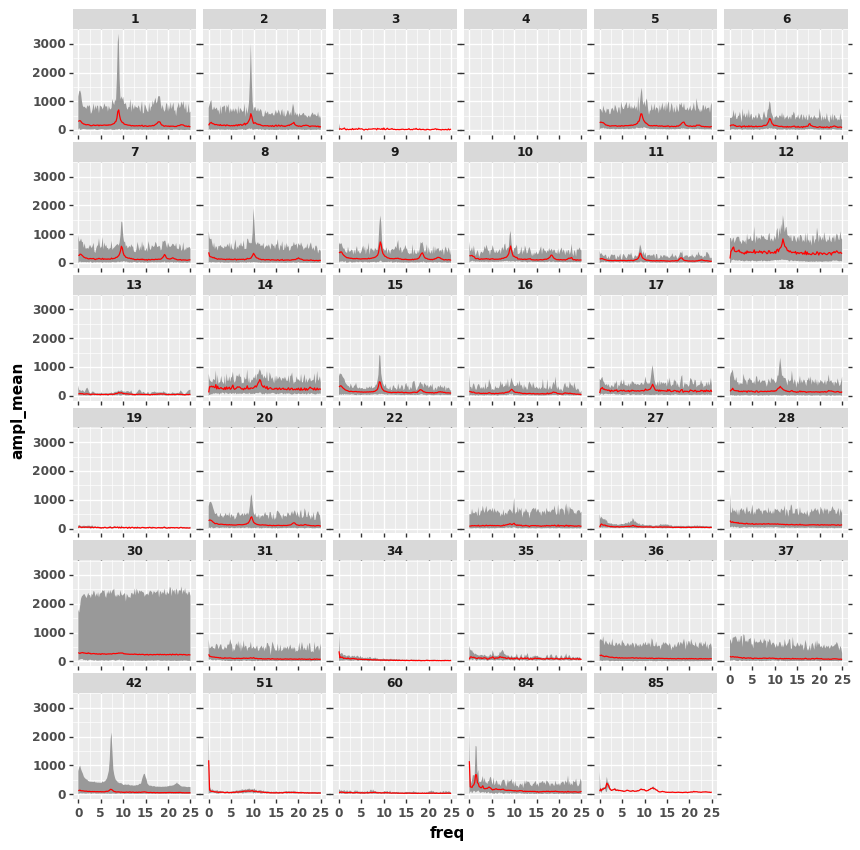

<ggplot: (114879171995)>

In [416]:
ggplot(data2[data2.clustertype=='extrude'], aes(x='freq', y='ampl_mean', ymin='ampl_ymin', ymax='ampl_ymax')) + \
    geom_ribbon(fill='#999999') + geom_line(color='red') + facet_wrap('~clusterid') + \
    theme(figure_size=(10,10))

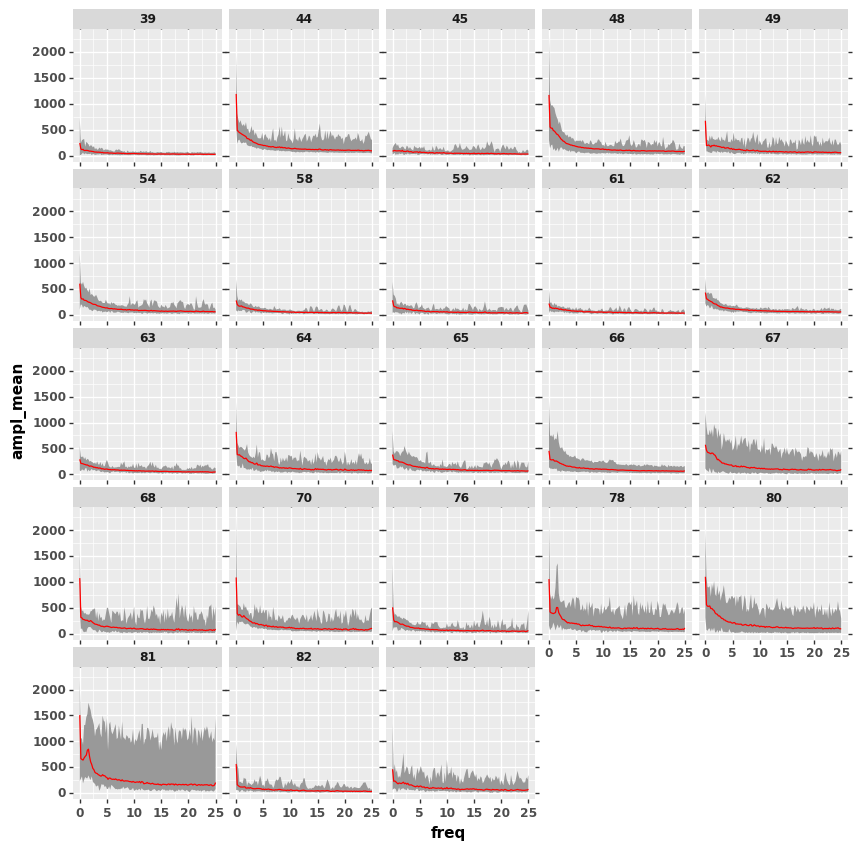

<ggplot: (-9223371921975347575)>

In [417]:
ggplot(data2[data2.clustertype=='extrude-slow'], aes(x='freq', y='ampl_mean', ymin='ampl_ymin', ymax='ampl_ymax')) + \
    geom_ribbon(fill='#999999') + geom_line(color='red') + facet_wrap('~clusterid') + \
    theme(figure_size=(10,10))

In [418]:
data2 = data.copy()
data2 = data2.groupby(['clustertype', 'freq']).agg({'ampl': ['mean', 'std', 'min', 'max']}).reset_index()
data2.loc[:,'ampl_mean'] = data2.ampl.loc[:,'mean']

data2.loc[:,'ampl_std'] = data2.ampl.loc[:,'std']
data2.loc[:,'ampl_ymin'] = data2.ampl_mean - data2.ampl_std
data2.loc[:,'ampl_ymax'] = data2.ampl_mean + data2.ampl_std

#data2.loc[:,'ampl_ymin'] = data2.ampl.loc[:,'min']
#data2.loc[:,'ampl_ymax'] = data2.ampl.loc[:,'max']

In [422]:
data3 = data.copy()
data3 = data3.groupby(['clustertype', 'clusterid', 'freq']).agg({'ampl': 'mean'}).reset_index()

In [ ]:
# + geom_line(color='red') + \

In [464]:
data2.ampl_ymin = np.maximum(data2.ampl_ymin, 0)

In [465]:
(ggplot(data2[data2.clustertype=='extrude'], aes(x='freq', y='ampl_mean', ymin='ampl_ymin', ymax='ampl_ymax')) + \
    geom_ribbon(fill='#999999') + geom_line(color='red') + \
    theme_bw() + theme(figure_size=(5,3)) + ylim(0, 900)).save('C:/Users/acorver/Desktop/paper-figures/Fig_Suppl_2C_R1.pdf')

In [466]:
(ggplot() + \
    geom_line(data=data3[data3.clustertype=='extrude'], alpha=0.4, 
              mapping=aes(x='freq', group='factor(clusterid)', y='ampl')) + \
    theme_bw() + theme(figure_size=(5,3)) + ylim(0, 900)).save('C:/Users/acorver/Desktop/paper-figures/Fig_Suppl_2C_R2.pdf')

In [467]:
(ggplot(data2[data2.clustertype=='extrude-slow'], aes(x='freq', y='ampl_mean', ymin='ampl_ymin', ymax='ampl_ymax')) + \
    geom_ribbon(fill='#999999') + geom_line(color='red') + \
    theme_bw() + theme(figure_size=(5,3)) + ylim(0, 900)).save('C:/Users/acorver/Desktop/paper-figures/Fig_Suppl_2C_R3.pdf')